# DVD Rental database
База представляет бизнес процессы магазина по аренде DVD.

В ней содержится 15 таблиц:

1. actor – хранит данные об актерах, включая их имя и фамилию.
2. film – хранит данные о фильмах, такие как название, год выпуска, продолжительность, рейтинг и т.д.
3. film_actor – хранит связи между фильмами и актерами.
4. category – хранит категории фильмов
5. film_category - хранит взаимосвязи между фильмами и категориями.
6. store – хранит данные магазина, включая управляющий состав и адрес.
7. inventory – хранит инвентарные номера фильмов по магазинам.
8. rental – хранит данные об аренде.
9. payment – хранит платежи клиентов.
10. staff – хранит данные персонала магазинов.
11. customer – хранит данные клиентов.
12. address – хранит адреса для персонала и клиентов.
13. city – хранит имена городов.
14. country – хранит названия стран.
15. language – хранит языки фильмов.

![схема базы](https://sp.postgresqltutorial.com/wp-content/uploads/2018/03/dvd-rental-sample-database-diagram.png)

**В таблице film удалены колонки rental_duration, rental_rate и replacement_cost. Стоимость определяется только по таблице payment**

У всех пользователей student_x есть доступ на чтение к этой базе данных. Название **dvdrental**.

# Задание
1. Проведите ABC анализ ассортимента. Выполняется ли для этих данных правило Парето? Если нет, то приведите подходящее на ваш взгляд разбиение
2. На основе полученного (общего) анализа ассортимента, оцените средний объем недельной выручки в каждой категории в привязке к дате начала аренды. В какой категории эта оценка имеет меньший разброс?
3. Используя оценки выручки из пункта 2 и категоризацию из пункта 1, постройте классификатор фильмов на основе актерского состава, языка, рейтинга (12+, 18+, см колонку rating) и продолжительности. При построении классификатора подберите пороговые значения для каждого класса так, чтобы максимизировать ожидаемую выручку. То-есть нужно предсказывать категории А,B,C. **Дополнительно, при сравнении моделей воспользуйтесь построением доверительных интервалов (t интервалов) для оценки диапазона значений метрик качества для каждого классификатора.**
4. В redash постройте дэшборд, отражающий динамику о кол-ве заказов каждую неделю, а также информацию о том какие фильмы ожидают возвращения в магазин и о клиентах (телефон, email), которые должны их вернуть.



In [61]:
# ваш код начинается здесь

#Задание №1

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model, ensemble
from sklearn.metrics import classification_report
from sklearn.exceptions import ConvergenceWarning
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, auc, roc_curve
from sklearn.model_selection import KFold, ParameterGrid
from statsmodels.stats.weightstats import _tconfint_generic
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
import psycopg2
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

Анализируем начальные данные задачи

In [63]:
# подключаемся к бд
DB_HOST = '89.223.95.138'
DB_USER = 'student_9'
DB_USER_PASSWORD = 'student_9'
DB_NAME = 'dvdrental'

conn = psycopg2.connect(host=DB_HOST, user=DB_USER, password=DB_USER_PASSWORD, dbname=DB_NAME)

In [64]:
# смотрю данные по таблице аренды
rental=pd.read_sql_query("select * from rental", conn)
rental.info() 
rental.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16044 entries, 0 to 16043
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   rental_id     16044 non-null  int64         
 1   rental_date   16044 non-null  datetime64[ns]
 2   inventory_id  16044 non-null  int64         
 3   customer_id   16044 non-null  int64         
 4   return_date   15861 non-null  datetime64[ns]
 5   staff_id      16044 non-null  int64         
 6   last_update   16044 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(4)
memory usage: 877.5 KB


,rental_id,rental_date,inventory_id,customer_id,return_date,staff_id,last_update
0,2,2005-05-24 22:54:33,1525,459,2005-05-28 19:40:33,1,2006-02-16 02:30:53
1,3,2005-05-24 23:03:39,1711,408,2005-06-01 22:12:39,1,2006-02-16 02:30:53
2,4,2005-05-24 23:04:41,2452,333,2005-06-03 01:43:41,2,2006-02-16 02:30:53
3,5,2005-05-24 23:05:21,2079,222,2005-06-02 04:33:21,1,2006-02-16 02:30:53
4,6,2005-05-24 23:08:07,2792,549,2005-05-27 01:32:07,1,2006-02-16 02:30:53


In [65]:
# смотрим данные таблицы платежи
payment=pd.read_sql_query("select * from payment", conn)
payment.info()
payment.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14596 entries, 0 to 14595
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   payment_id    14596 non-null  int64         
 1   customer_id   14596 non-null  int64         
 2   staff_id      14596 non-null  int64         
 3   rental_id     14596 non-null  int64         
 4   amount        14596 non-null  float64       
 5   payment_date  14596 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 684.3 KB


,payment_id,customer_id,staff_id,rental_id,amount,payment_date
0,17803,420,2,2672,3.99,2007-02-19 10:10:30.996577
1,18484,205,1,1767,0.99,2007-02-16 16:30:02.996577
2,18491,208,1,1949,5.99,2007-02-17 06:47:48.996577
3,19314,215,2,1599,4.99,2007-02-16 04:31:59.996577
4,19464,256,2,1973,4.99,2007-02-17 07:54:41.996577


In [66]:
# смотрим выручку, группирируя по фильмам
data_film = pd.read_sql_query("""
SELECT coalesce(sum(payment.amount), 0) as amount, film.film_id 
FROM film
LEFT JOIN inventory
ON film.film_id=inventory.film_id
LEFT JOIN rental
ON inventory.inventory_id=rental.inventory_id
LEFT JOIN payment
ON rental.rental_id=payment.rental_id
GROUP BY film.film_id
""", conn)
data_film.info() 
data_film

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   amount   1000 non-null   float64
 1   film_id  1000 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 15.8 KB


,amount,film_id
0,407.41,652
1,560.40,273
2,682.77,51
3,542.54,951
4,138.40,839
...,...,...
995,256.81,64
996,454.36,55
997,0.00,148
998,513.58,790


Анализируем аренду и платежи фильмов по id фильма

Строим сводную таблицу и передаюм в датафрейм

Добавляем в таблицу колонки процент данного фильма от общей количества фильмов и кумулятивную сумму выручки

Строим график зависимости кумулятивной суммы выручки от процента фильмов, используемым в данной сумме 


In [67]:
# добавляем процент выручки каждого фильма от общей выручки
data_film['amount_percent'] = data_film['amount'] / data_film['amount'].sum() * 100
data_film.head()

,amount,film_id,amount_percent
0,407.41,652,0.108684
1,560.40,273,0.149497
2,682.77,51,0.182141
3,542.54,951,0.144732
4,138.40,839,0.036921


In [68]:
# находим куммулятивный процент выручки, располагая фильмы по убыванию выручки
data_film = data_film.sort_values(['amount_percent'], ascending=False).reset_index()
data_film['amount_percent_cumsum'] = data_film['amount_percent'].cumsum()
data_film

,index,amount,film_id,amount_percent,amount_percent_cumsum
0,907,930.62,973,0.248259,0.248259
1,789,925.53,767,0.246901,0.495160
2,924,911.81,1000,0.243241,0.738402
3,314,849.70,361,0.226672,0.965074
4,329,842.55,31,0.224765,1.189839
...,...,...,...,...,...
995,415,0.00,642,0.000000,100.000000
996,371,0.00,713,0.000000,100.000000
997,822,0.00,14,0.000000,100.000000
998,484,0.00,87,0.000000,100.000000


In [69]:
# добавляем столбем процент текущего фильма от общего количества фильмов 
data_film['index_percent'] = data_film.index/data_film.index.max()*100
data_film

,index,amount,film_id,amount_percent,amount_percent_cumsum,index_percent
0,907,930.62,973,0.248259,0.248259,0.0000
1,789,925.53,767,0.246901,0.495160,0.1001
2,924,911.81,1000,0.243241,0.738402,0.2002
3,314,849.70,361,0.226672,0.965074,0.3003
4,329,842.55,31,0.224765,1.189839,0.4004
...,...,...,...,...,...,...
995,415,0.00,642,0.000000,100.000000,99.5996
996,371,0.00,713,0.000000,100.000000,99.6997
997,822,0.00,14,0.000000,100.000000,99.7998
998,484,0.00,87,0.000000,100.000000,99.8999


In [70]:
import plotly.graph_objects as go
fig = go.Figure()
# график отражает процент выручки для выбранного процента фильмов
fig.add_trace(go.Scatter(y=data_film['amount_percent_cumsum'], x=data_film['index_percent'], line=dict(width=1)))

Проводим ABC анализ, используя разбиение в соответствии с принципом Парето

In [71]:
def ABC_segmentation(perc):
  if perc < 80:
    return 'A'
  if perc >= 80 and perc < 95:
    return 'B'
  if perc >= 95:
    return 'C'

In [72]:
data_film['ABC_category'] = data_film['amount_percent_cumsum'].apply(ABC_segmentation)
data_film

,index,amount,film_id,amount_percent,amount_percent_cumsum,index_percent,ABC_category
0,907,930.62,973,0.248259,0.248259,0.0000,A
1,789,925.53,767,0.246901,0.495160,0.1001,A
2,924,911.81,1000,0.243241,0.738402,0.2002,A
3,314,849.70,361,0.226672,0.965074,0.3003,A
4,329,842.55,31,0.224765,1.189839,0.4004,A
...,...,...,...,...,...,...,...
995,415,0.00,642,0.000000,100.000000,99.5996,C
996,371,0.00,713,0.000000,100.000000,99.6997,C
997,822,0.00,14,0.000000,100.000000,99.7998,C
998,484,0.00,87,0.000000,100.000000,99.8999,C


In [73]:
vc = pd.DataFrame(np.array(data_film['ABC_category'].value_counts()), columns=['films_count'])
vc['films_count_percent'] = vc['films_count']/vc['films_count'].sum()
vc

,films_count,films_count_percent
0,608,0.608
1,225,0.225
2,167,0.167


Выводы: принцип Парето для данного набора данных не выполняется, категория А является самой многочисленной категорией фильмов

# Задание №2

Собираю данные о датах аренды и суммах выручки по каждому фильму

In [74]:
data=pd.read_sql_query("""
SELECT rental.rental_date, amount, payment_date, film.film_id 
FROM  rental
LEFT JOIN  payment
ON payment.rental_id=rental.rental_id
LEFT JOIN inventory
ON rental.inventory_id=inventory.inventory_id
LEFT JOIN film
ON inventory.film_id=film.film_id
""", conn)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16048 entries, 0 to 16047
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   rental_date   16048 non-null  datetime64[ns]
 1   amount        14596 non-null  float64       
 2   payment_date  14596 non-null  datetime64[ns]
 3   film_id       16048 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 501.6 KB


,rental_date,amount,payment_date,film_id
0,2005-06-19 11:42:04,3.99,2007-02-19 10:10:30.996577,257
1,2005-06-16 18:01:36,0.99,2007-02-16 16:30:02.996577,257
2,2005-06-17 08:19:22,5.99,2007-02-17 06:47:48.996577,323
3,2005-06-16 06:03:33,4.99,2007-02-16 04:31:59.996577,323
4,2005-06-17 09:26:15,4.99,2007-02-17 07:54:41.996577,803


Для каждой записи из базы фильмов присваиваю категорию фильма 
обращаю внимание что выдач 16048, а возвратов 14596, значит имеем 183 случая невозвратов фильмов


In [75]:
categories_dict = data_film[['film_id','ABC_category']].set_index('film_id').to_dict()
data['ABC_category'] = data['film_id'].map(categories_dict['ABC_category'])
data
 

,rental_date,amount,payment_date,film_id,ABC_category
0,2005-06-19 11:42:04,3.99,2007-02-19 10:10:30.996577,257,C
1,2005-06-16 18:01:36,0.99,2007-02-16 16:30:02.996577,257,C
2,2005-06-17 08:19:22,5.99,2007-02-17 06:47:48.996577,323,C
3,2005-06-16 06:03:33,4.99,2007-02-16 04:31:59.996577,323,C
4,2005-06-17 09:26:15,4.99,2007-02-17 07:54:41.996577,803,C
...,...,...,...,...,...
16043,2005-05-26 08:14:15,NaN,NaT,391,A
16044,2005-05-31 17:45:49,NaN,NaT,526,A
16045,2005-05-31 04:53:40,NaN,NaT,895,A
16046,2005-06-19 14:12:22,NaN,NaT,859,A


Группирую данные по категориям фильмов, по неделям, обращаю внимание что есть пустые недели 

In [76]:
data_weekly_by_category = data.reset_index()[['ABC_category', 'rental_date', 'amount']]
data_weekly_by_category = data_weekly_by_category.groupby([ 'ABC_category', pd.Grouper(key='rental_date', freq='1W')]).mean()
data_weekly_by_category


amount
ABC_category rental_date           
A            2005-05-29         NaN
             2005-06-05         NaN
             2005-06-19   26.292633
             2005-06-26   26.394512
             2005-07-10   26.398888
             2005-07-17   26.002995
             2005-07-31   26.227241
             2005-08-07   26.567321
             2005-08-21   26.215355
             2005-08-28   26.546926
             2006-02-19   26.317586
B            2005-05-29         NaN
             2005-06-05         NaN
             2005-06-19   23.747788
             2005-06-26   24.605422
             2005-07-10   23.913664
             2005-07-17   24.021509
             2005-07-31   23.755952
             2005-08-07   24.133861
             2005-08-21   24.011016
             2005-08-28   23.847087
             2006-02-19   22.868148
C            2005-05-29         NaN
             2005-06-05         NaN
             2005-06-19   21.724286
             2005-06-26   21.384828
             2005-07-10   22.338777
             2005-07-17   21.675306
             2005-07-31   22.117813
             2005-08-07   22.912222
             2005-08-21   21.898934
             2005-08-28   22.756667
             2006-02-19   23.203000

Считаю стандартное отклонение еженедельной выручки по каждой категории фильма

In [77]:
data_weekly_by_category_std = data_weekly_by_category.groupby([ 'ABC_category']).std()
data_weekly_by_category_std

,amount
ABC_category,
A,0.174809
B,0.459181
C,0.622588


В категории А оценка имеет наименьший разброс

Также посчитаю среднее значение еженедельной выручки для каждой категории фильма 

In [78]:
data_weekly_by_category_mean = data_weekly_by_category.groupby([ 'ABC_category']).mean()
data_weekly_by_category_mean

,amount
ABC_category,
A,26.329273
B,23.878272
C,22.223537


# Задание №3

Собираем данные о фильмах: выручку, актерский состав, рейтинг, язык, категорию

In [79]:
data_films_baze = pd.read_sql_query("""
SELECT film.film_id, film.rating, film.length, max(film_category.category_id) as category_id, language_id, coalesce(sum(payment.amount), 0) as amount, count(actor_id) AS count_actor
FROM film 

LEFT JOIN film_category
ON film.film_id=film_category.film_id
LEFT JOIN film_actor
ON film.film_id=film_actor.film_id
LEFT JOIN inventory
ON film.film_id=inventory.film_id
LEFT JOIN rental
ON inventory.inventory_id=rental.inventory_id
LEFT JOIN payment
ON rental.rental_id=payment.rental_id
GROUP BY film.film_id
""", conn)
data_films_baze.info()
data_films_baze.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   film_id      1000 non-null   int64  
 1   rating       1000 non-null   object 
 2   length       1000 non-null   int64  
 3   category_id  1000 non-null   int64  
 4   language_id  1000 non-null   int64  
 5   amount       1000 non-null   float64
 6   count_actor  1000 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 54.8+ KB


,film_id,rating,length,category_id,language_id,amount,count_actor
0,652,R,126,4,1,2037.05,70
1,273,PG,107,8,1,3922.80,175
2,51,NC-17,75,12,1,4096.62,138
3,951,PG-13,78,4,1,2712.70,140
4,839,PG-13,130,14,1,968.80,49


Добавляем категори фильма

In [80]:
categories_dict_2 = data_film[['film_id','ABC_category']].set_index('film_id').to_dict()
data_films_baze['ABC_category'] = data_films_baze['film_id'].map(categories_dict_2['ABC_category'])
data_films_baze

,film_id,rating,length,category_id,language_id,amount,count_actor,ABC_category
0,652,R,126,4,1,2037.05,70,A
1,273,PG,107,8,1,3922.80,175,A
2,51,NC-17,75,12,1,4096.62,138,A
3,951,PG-13,78,4,1,2712.70,140,A
4,839,PG-13,130,14,1,968.80,49,C
...,...,...,...,...,...,...,...,...
995,64,PG-13,151,7,1,1540.86,66,B
996,55,G,65,14,1,2271.80,125,A
997,148,R,132,9,1,0.00,7,C
998,790,PG-13,67,7,1,1540.74,72,A


In [81]:
mean_by_category = data[['ABC_category',  'amount']]
df=mean_by_category.groupby([ 'ABC_category']).mean()
df

,amount
ABC_category,
A,26.311429
B,23.915085
C,22.153721


Применяем one-hot encoding для категориальныx столбцов

In [82]:
data_films_baze['rating'] = data_films_baze['rating'].astype('category')
data_films_baze['language_id'] = data_films_baze['language_id'].astype('category')
data_films_baze['category_id'] = data_films_baze['category_id'].astype('category')
ohe_data_films_baze=pd.get_dummies(data_films_baze, columns=['rating', 'language_id', 'category_id'])
ohe_data_films_baze

,film_id,length,amount,count_actor,ABC_category,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,language_id_1,category_id_1,category_id_2,category_id_3,category_id_4,category_id_5,category_id_6,category_id_7,category_id_8,category_id_9,category_id_10,category_id_11,category_id_12,category_id_13,category_id_14,category_id_15,category_id_16
0,652,126,2037.05,70,A,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,273,107,3922.80,175,A,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,51,75,4096.62,138,A,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,951,78,2712.70,140,A,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,839,130,968.80,49,C,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,64,151,1540.86,66,B,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
996,55,65,2271.80,125,A,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
997,148,132,0.00,7,C,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
998,790,67,1540.74,72,A,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


Обращаем внимание, что язык везде только английский хотя справочник предусматривает 6 языков

Формируем датафрейм данных и датафрейм категорий

In [83]:
log_y = ohe_data_films_baze['ABC_category'].values
log_x= ohe_data_films_baze.drop(['ABC_category', 'amount', 'film_id'], axis = 1, inplace=False)

In [84]:
log_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   length          1000 non-null   int64
 1   count_actor     1000 non-null   int64
 2   rating_G        1000 non-null   uint8
 3   rating_NC-17    1000 non-null   uint8
 4   rating_PG       1000 non-null   uint8
 5   rating_PG-13    1000 non-null   uint8
 6   rating_R        1000 non-null   uint8
 7   language_id_1   1000 non-null   uint8
 8   category_id_1   1000 non-null   uint8
 9   category_id_2   1000 non-null   uint8
 10  category_id_3   1000 non-null   uint8
 11  category_id_4   1000 non-null   uint8
 12  category_id_5   1000 non-null   uint8
 13  category_id_6   1000 non-null   uint8
 14  category_id_7   1000 non-null   uint8
 15  category_id_8   1000 non-null   uint8
 16  category_id_9   1000 non-null   uint8
 17  category_id_10  1000 non-null   uint8
 18  category_id_11  1000 non-null

In [85]:
log_x

,length,count_actor,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,language_id_1,category_id_1,category_id_2,category_id_3,category_id_4,category_id_5,category_id_6,category_id_7,category_id_8,category_id_9,category_id_10,category_id_11,category_id_12,category_id_13,category_id_14,category_id_15,category_id_16
0,126,70,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,107,175,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,75,138,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,78,140,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,130,49,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,151,66,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
996,65,125,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
997,132,7,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
998,67,72,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


Делим выборку на тест и трейн

In [86]:
log_x_train, log_x_test, log_y_train, log_y_test = model_selection.train_test_split (log_x, log_y, test_size=0.2)

Строим логистическую регрессию и оцениваем ее точность кроссвалидацией и точность на тестовых данных

In [87]:
logistic_regression_model = linear_model.LogisticRegression(max_iter=2000).fit(log_x_train, log_y_train) 

In [88]:
cv = cross_val_score(logistic_regression_model, X=log_x_train, y=log_y_train, cv=20)
cv.mean()

0.7187500000000001

In [89]:
log_y_predict = logistic_regression_model.predict(log_x_test)
logistic_regression_model.score(log_x_test, log_y_test)

0.685

In [90]:
# выводим матрицу сопряжений
confusion_matrix(log_y_predict, log_y_test)

array([[106,  35,   5],
       [  7,   4,   2],
       [  6,   8,  27]])

Пробуем другие модели

In [91]:
!pip install catboost

In [92]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=1000, learning_rate=0.01, depth=5, loss_function='MultiClass', silent=True)

In [93]:
model.fit(X=log_x_train, y=log_y_train)

In [94]:
cv = cross_val_score(model, X=log_x_train, y=log_y_train, cv=20)
cv.mean()

0.7137499999999999

In [95]:
cb_y_predict = model.predict(log_x_test)
accuracy_score(log_y_test, cb_y_predict)

0.685

In [96]:
confusion_matrix(cb_y_predict, log_y_test)

array([[105,  34,   7],
       [ 10,   7,   2],
       [  4,   6,  25]])

Наилучший результат дает модель логистической регресии, продолжаем анализ


In [97]:
# нахожу интервалы вероятности отнесения фильма к классам
log_y_predict_pr = logistic_regression_model.predict_proba(log_x_test) 
log_y_predict_pr [:5, :]

array([[8.43237773e-01, 1.44700844e-01, 1.20613828e-02],
       [8.82303556e-01, 1.14081893e-01, 3.61455151e-03],
       [4.37331978e-01, 5.27947890e-01, 3.47201315e-02],
       [9.95335692e-01, 4.66401730e-03, 2.90339051e-07],
       [9.96451643e-01, 3.54802456e-03, 3.31978366e-07]])

Построим графики для каждого класса чтобы лучше увидеть интервалы


(array([82., 17.,  5.,  5.,  4.,  5.,  3.,  5.,  2.,  2.,  3.,  0.,  2.,
         2.,  3.,  1.,  0.,  0.,  4.,  3.,  1.,  2.,  1.,  1.,  0.,  2.,
         1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  2.,  3.,  0.,  0.,  2.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  2.,  1.,
         0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,
         0.,  0.,  0.,  0.,  1.,  1.,  2.,  0.,  0.,  1.,  1.,  3.,  0.,
         1.,  2.,  0.,  1.,  0.,  2.,  0.,  0.,  1.]),
 array([1.57247939e-09, 9.48774510e-03, 1.89754886e-02, 2.84632321e-02,
        3.79509757e-02, 4.74387192e-02, 5.69264627e-02, 6.64142062e-02,
        7.59019498e-02, 8.53896933e-02, 9.48774368e-02, 1.04365180e-01,
        1.13852924e-01, 1.23340667e-01, 1.32828411e-01, 1.42316154e-01,
        1.51803898e-01, 1.61291641e-01, 1.70779385e-01, 1.80267129e-01,
        1.89754872e-01, 1.99242616e-01, 2.08730359e-01, 2.18218103e-01,
  

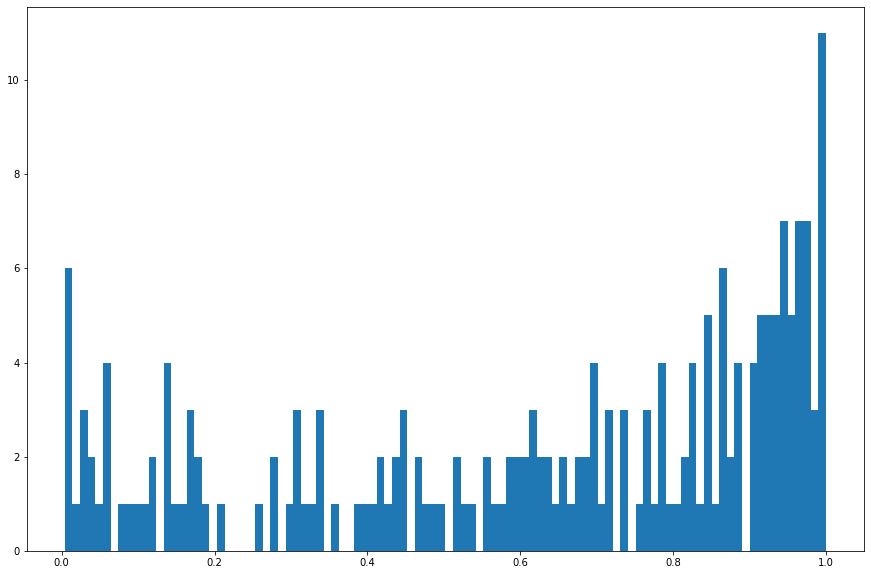

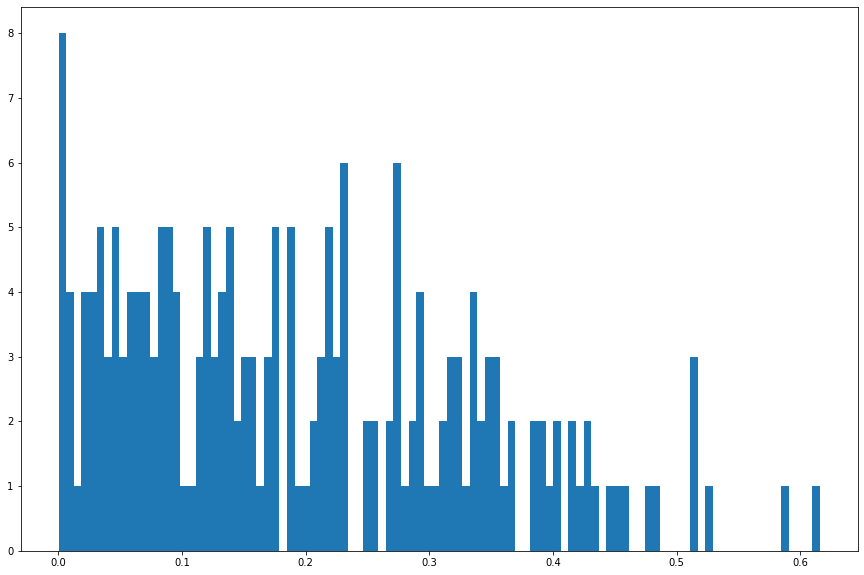

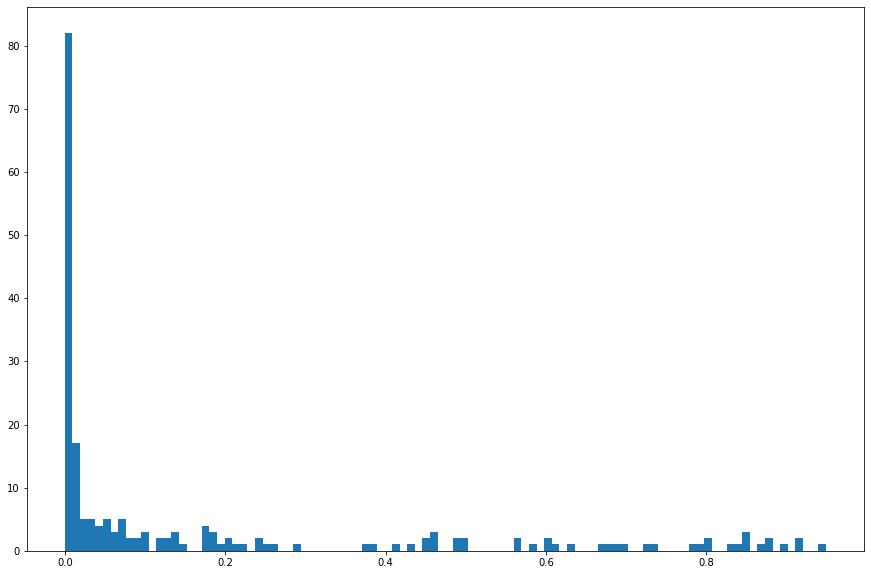

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.hist(log_y_predict_pr[:,0], bins=100)

plt.figure(figsize=(15, 10))
plt.hist(log_y_predict_pr[:,1], bins=100)

plt.figure(figsize=(15, 10))
plt.hist(log_y_predict_pr[:,2], bins=100)



Оценим модель с помощью roc_auc и roc_curve

In [99]:
roc_auc_value = roc_auc_score(log_y_test, log_y_predict_pr, multi_class='ovr')
roc_auc_value

0.8342165482470549

In [100]:
df.to_dict()['amount']

{'A': 26.311429323968323, 'B': 23.915084961767185, 'C': 22.153720657276985}

In [101]:
log_y_test_matrix = pd.get_dummies(log_y_test).values

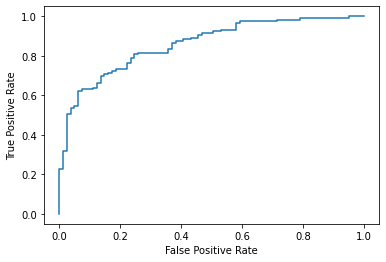

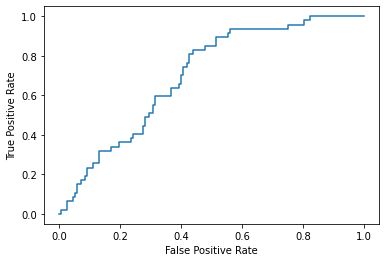

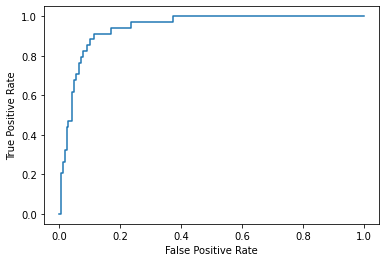

In [102]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
  fpr[i], tpr[i], _ = roc_curve(log_y_test_matrix[:, i], log_y_predict_pr[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(3):
  plt.figure()
  plt.plot(fpr[i], tpr[i], label='RCOE curve (area = %0.2f)' % roc_auc[i])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.show()


Подбираем лучшую модель, пороговые значения для каждого класса, максимизируя нашу метрику (максимизируем ожидаемую выручку с задаваемыми потерями при ошибочном определении класса). Подбираем, используя кроссвалидацию. Строим доверительные t-интервалы для этой модели.

In [103]:
def handle_function(function, arguments):
    return function(**arguments)

In [104]:
def metrica_mean_amount(y_test, y_test_predict):
  amount = 0
  for i in range(0, len(y_test)):
    if y_test[i] == y_test_predict[i]:
      amount += df.to_dict()['amount'][y_test[i]] 
    else:
      amount -= abs(df.to_dict()['amount'][y_test[i]] - df.to_dict()['amount'][y_test_predict[i]])
  return amount

In [105]:
def get_t_interval(scores):
  mean = scores.mean()
  mean_std = scores.std(ddof=1)/np.sqrt(len(scores))
  return (
      "model mean auc 95%% confidence interval : ", 
      _tconfint_generic(mean, mean_std, len(scores) - 1, 0.05, 'two-sided')
  )

In [106]:
def check_models_cv(models, X, y):
  max = 0
  score_string = ''
  max_model = ''
  score_t_interval = ''
  for model in models:
    # print("Model: %s" % model)

    for parameters in ParameterGrid(model['parameters']):
      # print("parameters: %s" % parameters)
      kf = KFold(n_splits=10)
      y_scores = dict()

      for train_index, test_index in kf.split(y):
        current_model = handle_function(model['base'], parameters)
        X_train, X_test = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
        y_train, y_test = y[train_index], y[test_index]
        y_predict_proba = current_model.fit(X_train, y_train).predict_proba(X_test)
        
        for probAint in range(5,95):
          for probBint in range(5,95):            
            probA = round((probAint/100),2)
            probB = round((probBint/100),2)
            probC = round((1 - probA - probB),2)
            if probC <=0:
              continue
            prob_names = f'PROB {probA} : {probB} : {probC}'
            if prob_names not in y_scores.keys():
              y_scores[prob_names] = []
            y_predict = list(map(lambda x: 'A' if x[0]>=probA else 'B' if x[1]>=probB else 'C', y_predict_proba))
            current_score = metrica_mean_amount(y_test, y_predict)
            # current_score = accuracy_score(y_test, y_predict) # можно сравнить результаты точности метрики по средней выручке и accuracy
            y_scores[prob_names].append(current_score)

      for y_score_name in y_scores:
        score_mean = np.array(y_scores[y_score_name]).mean()
        if score_mean > max:
          max = score_mean
          max_model = str(model['base']) + ' : ' + str(parameters) + ' : '+ y_score_name
          score_std = np.array(y_scores[y_score_name]).std(ddof=1)
          score_t_interval = get_t_interval(np.array(y_scores[y_score_name])) #расчет t интервала
          score_string = "Mean cv metric: %0.3f (%0.3f)" % (score_mean, score_std)

  print("Best model")
  print(max_model)
  print(score_string)
  print(score_t_interval)

In [108]:
check_models_cv(
    [
      {
         'base': KNeighborsClassifier, 
         'parameters': {'n_neighbors': [2,3,4,5,6,7]}
      },   
      {
         'base': linear_model.LogisticRegression,
         'parameters': {'max_iter': [1500], 'C': [0.01, 0.1, 1, 10], 'solver': ['newton-cg', 'saga', 'liblinear']}
      },     
      {
         'base': GaussianNB,
         'parameters': {'priors': [None], 'var_smoothing': np.logspace(0,-9, num=50)}
      }
    ],
    log_x,
    log_y
    )

Best model
<class 'sklearn.linear_model._logistic.LogisticRegression'> : {'C': 1, 'max_iter': 1500, 'solver': 'newton-cg'} : PROB 0.33 : 0.43 : 0.24
Mean cv metric: 1774.998 (103.309)
('model mean auc 95%% confidence interval : ', (1701.0957980679732, 1848.9011680460217))


Вывод: на текущих данных наиболее высокие результаты дает модель логичестической регрессии  имеющей следующие параметры: {'C': 1, 'max_iter': 1500, 'solver': 'newton-cg'} 

Пороговые значения классов PROB 0.33 : 0.43 : 0.24

Оценка по средней доходности 1774.998

Данные построенных t-интервалов (1701.0957980679732, 1848.9011680460217)
